# Pachete folosite

In [1]:
from scipy import misc, ndimage, signal
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from IPython.display import Audio

# Rezolvare exercițiul 1

Definesc o funcție care să genereze (prin eșantionare) un semnal 2D.
- `f` este semnalul.
- `size` este dimensiunea imaginii generate. Este echivalentul duratei pe care eșantionez semnalul 1D.
- `step` este distanța dintre eșantioane. Cu cât este mai mic, cu atât crește rata de eșantionare.

In [2]:
def generate_and_plot(f, size, step):
    # Folosesc mgrid pentru a genera o matrice de puncte
    N1, N2 = np.mgrid[0:size:step, 0:size:step]

    # Eșantionez semnalul
    y = f(N1, N2)
    
    # Aplic transformarea Fourier
    Y = np.fft.fft2(y)
    
    Y = Y[:Y.shape[0]//2, :Y.shape[1]//2]
    
    # Adun un epsilon înainte de a logaritma, pentru a evita log(0)
    epsilon = np.finfo(float).eps
    
    # Transform într-o scară logaritmică
    Y_scaled = 20 * np.log10(np.abs(Y) + epsilon)
    
    # Generez o figură cu două sub-grafice
    fig, ax = plt.subplots(1, 2, dpi=150)

    ax[0].set_title("Semnalul original")
    ax[0].imshow(y)

    ax[1].set_title("Domeniul frecvență")
    ax[1].imshow(Y_scaled)

    plt.show()

## Prima funcție

$x_{n_1,n_2} = \sin(2\pi n_1 + 3\pi n_2)$

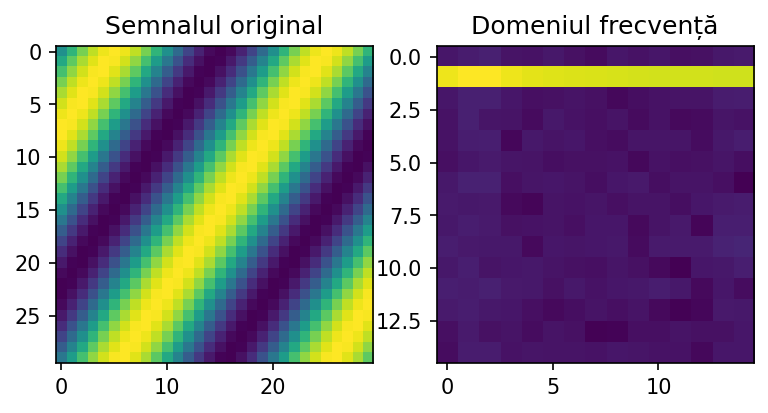

In [3]:
def f1(n1, n2):
    return np.sin(2 * np.pi * n1 + 3 * np.pi * n2)

generate_and_plot(f1, 1, 1/30)

Semnalul original are mai multe „benzi” paralele.

## A doua funcție

$x_{n_1,n_2} = \sin(4\pi n_1) + \cos(6\pi n_2)$

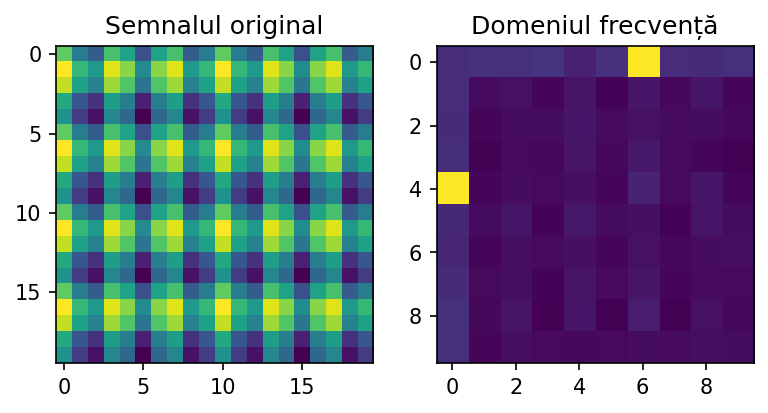

In [4]:
def f2(n1, n2):
    return np.sin(4 * np.pi * n1) + np.cos(6 * np.pi * n2)

generate_and_plot(f2, 2, 1/10)

În domeniul frecvență se poate vedea că semnalul este format din două componente ortogonale, și că pe orizontală este componenta de frecvență mai mare.

## Din domeniul frecvenței în cel al timpului

Redefinesc funcția pentru a face transformarea inversă:

In [5]:
def generate_and_plot(f, size, step):
    # Folosesc mgrid pentru a genera o matrice de puncte
    N1, N2 = np.mgrid[0:size:step, 0:size:step]

    # Eșantionez semnalul transformat
    Y = f(N1, N2)
    
    # Aplic transformarea Fourier inversă
    y = np.fft.ifft2(Y).real
    
    # Generez o figură cu două sub-grafice
    fig, ax = plt.subplots(1, 2, dpi=150)

    Y = Y[:Y.shape[0]//2, :Y.shape[1]//2]
    
    ax[0].set_title("Domeniul frecvență")
    ax[0].imshow(Y)
    
    ax[1].set_title("Semnalul original")
    ax[1].imshow(y)

## A treia funcție

$Y_{0,5} = Y_{0,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$

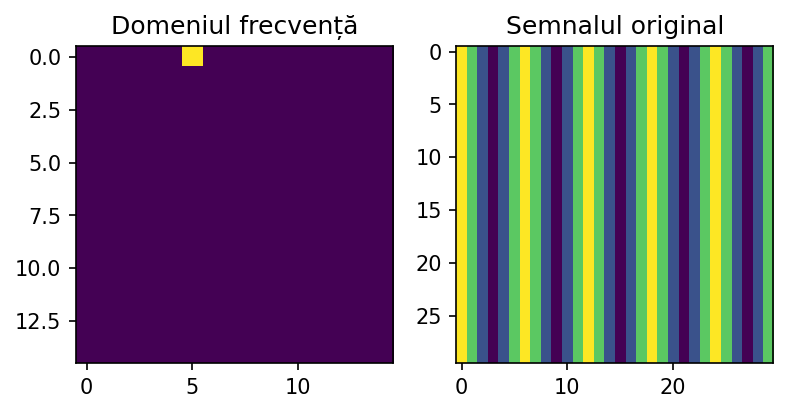

In [6]:
N = 30

def f3(n1, n2):
    condition = (n1 == 0) & ((n2 == 5) | (n2 == N - 5))
    return np.where(condition, 1, 0)

generate_and_plot(f3, N, 1)

În domeniul frecvență avem o singură componentă, exclusiv pe orizontală. Semnalul original este format din benzi paralele cu Oy.

# A patra funcție

$Y_{5,0} = Y_{N-5,0} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$

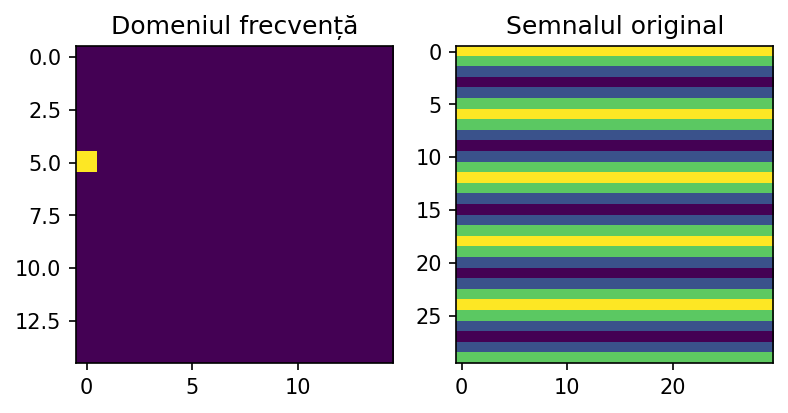

In [7]:
N = 30

def f4(n1, n2):
    condition = ((n1 == 5) | (n1 == N - 5)) & (n2 == 0)
    return np.where(condition, 1, 0)

generate_and_plot(f4, N, 1)

În domeniul frecvență avem o singură componentă, exclusiv pe verticală. Semnalul original este format din benzi paralele cu Ox.

## A cincea funcție

$Y_{5,5} = Y_{N-5,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$

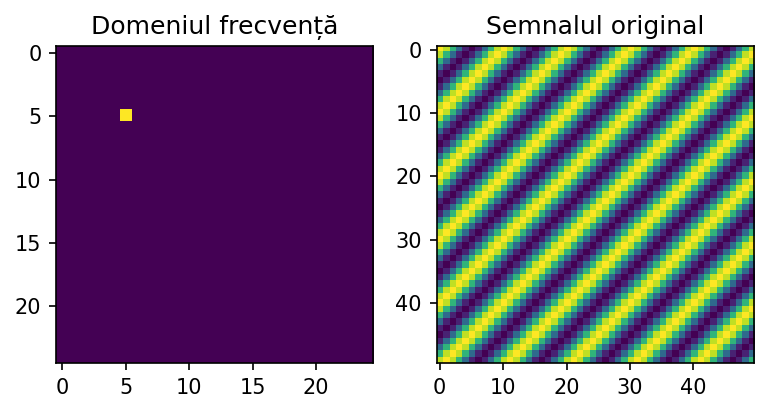

In [8]:
N = 50

def f5(n1, n2):
    condition = ((n1 == 5) & (n2 == 5)) | ((n1 == (N - 5)) & (n2 == (N - 5)))
    return np.where(condition, 1, 0)

generate_and_plot(f5, N, 1)

În domeniul frecvență vedem că semnalul este format dintr-o singură, componentă de frecvențe egale pe orizontală și verticală. Semnalul original este format din benzi paralele, la ${45}^\circ$ față de axele de coordonate.

# Rezolvare exercițiul 2

Am încercat diferite nivele pentru threshold și am afișat rezultatele obținute, împreună cu SNR-ul lor.

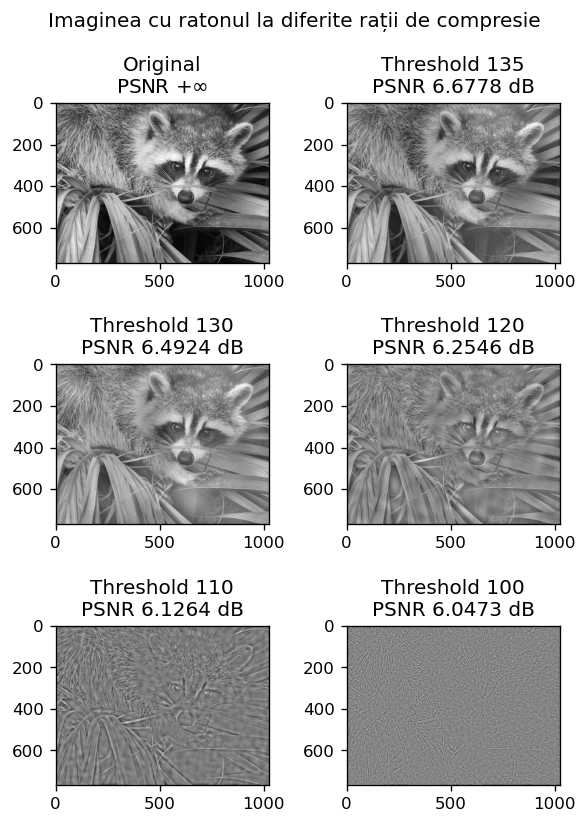

In [9]:
# Folosesc formula din https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
def compute_psnr(original, noisy):
    "Calculează peak signal-to-noise ratio pentru imaginea dată."

    # Calculez eroarea medie pătratică
    squared_diffs = (original - noisy) ** 2
    mse = np.mean(squared_diffs)
    if mse == 0:
        # Dacă semnalele sunt identice, nu există noise
        return np.inf
    
    # Găsesc pixelul cel mai luminos din imaginea originală
    max_intensity = np.max(original)
    
    # Calculez raportul PSNR
    ratio = (max_intensity ** 2) / mse
    
    # Convertesc în decibeli
    return 10 * np.log10(ratio)


def filter_image(original, threshold):
    "Filtrează frecvențele mai mari de `threshold` dB din imaginea dată ca parametru."
    
    # Transform în domeniul frecvenței
    Y = np.fft.rfft2(original)
    # Aduc la scară logaritmică
    Y_amp_db = 20 * np.log10(np.abs(Y))
    
    # Atenuez frecvențele de amplitudine mare
    Y[Y_amp_db > threshold] = 0

    # Aplic transformarea inversă
    return np.fft.irfft2(Y)

def filter_and_plot(ax, threshold):
    original = misc.face(gray=True)
    filtered = filter_image(original, threshold)
    psnr = compute_psnr(original, filtered)
    ax.imshow(filtered, cmap=plt.cm.gray)
    ax.set_title(f'Threshold {threshold}\nPSNR {psnr:.4f} dB')
    

fig, ax = plt.subplots(3, 2, figsize=(5, 7), dpi=120)
plt.suptitle('Imaginea cu ratonul la diferite rații de compresie')

X = misc.face(gray=True)
ax[0][0].imshow(X, cmap=plt.cm.gray)
ax[0][0].set_title('Original\nPSNR $+\infty$')

filter_and_plot(ax[0][1], 135)
filter_and_plot(ax[1][0], 130)
filter_and_plot(ax[1][1], 120)
filter_and_plot(ax[2][0], 110)
filter_and_plot(ax[2][1], 100)

plt.tight_layout()
plt.show()

# Rezolvare exercițiul 3

Am generat zgomot și l-am adăugat imaginii originale. Pentru a elimina zgomotul, am aplicat o fereastră care să netezească imaginea.

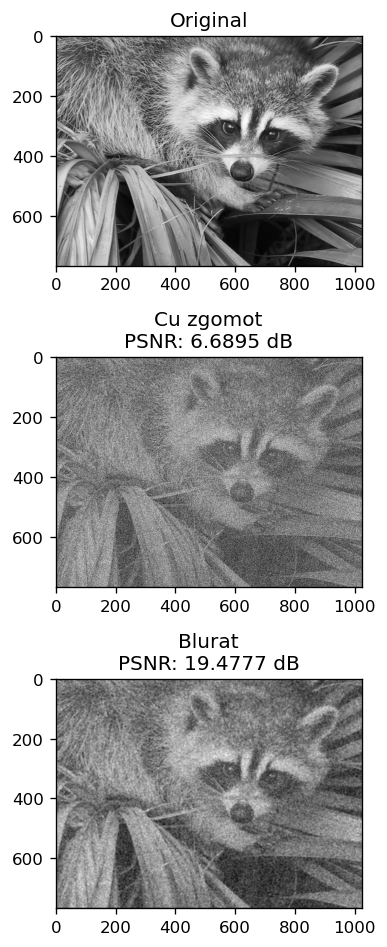

In [10]:
original = misc.face(gray=True)

# Generez și aplic zgomotul pe imagine
pixel_noise = 200
noise = np.random.randint(-pixel_noise, high=pixel_noise+1, size=original.shape)
noisy = original + noise

# Construiesc un filtru care să blureze imaginea
size = 5
average_kernel = np.ones((size, size))/(size ** 2)
filtered = signal.convolve2d(noisy, average_kernel, mode='same')

# Afișez diferitele versiuni
fig, ax = plt.subplots(3, 1, figsize=(4, 8), dpi=120)

ax[0].imshow(original, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(noisy, cmap=plt.cm.gray)
psnr = compute_psnr(original, noisy)
ax[1].set_title(f'Cu zgomot\nPSNR: {psnr:.4f} dB')

ax[2].imshow(filtered, cmap=plt.cm.gray)
psnr = compute_psnr(original, filtered)
ax[2].set_title(f'Blurat\nPSNR: {psnr:.4f} dB')

plt.tight_layout()
plt.show()

# Rezolvare exercițiul 4

Porțiunea aleasă de la începutul melodiei conține clape și tobe:

In [11]:
# Citesc o porțiune din fișierul audio de la laboratorul 3
with open('segment-lab3.wav', 'rb') as fin:
    sampling_rate, samples = wavfile.read(fin)

Audio(samples, rate=sampling_rate)

Eliminând frecvențele joase, nu se mai aude toba mare în audio:

In [12]:
Y = np.fft.rfft(samples)

Y[:2500] = 0

X = np.fft.irfft(Y)

print('Audio filtrat:')
Audio(X, rate=sampling_rate)

Audio filtrat:
